In [2]:
import os
import numpy as np
import pandas as pd
import shutil
if os.getcwd().endswith("notebooks"):
    os.chdir("..")
    home_dir = os.getcwd()

from gexpress_testing.utilities.utilities import filter_data, cleanup_storage, get_final_data_list
from gexpress_testing.utilities.utilities import get_tt_split

nonred_id_path = os.path.join(home_dir, "..", "EpiMapID_Name_nonDup.txt")

os.mkdir("/scratch/temp")

In [3]:
with open(nonred_id_path, "r", encoding='utf-8') as fhandle:
    nonredundant_ids = [l.split()[0] for l in fhandle]

In [4]:
#Unfortunately the file paths here are hard-coded. Find a better solution to this (config file perhaps)
pfiles, yfiles = get_final_data_list("/stg3/data1/sam/enhancer_prediction/fimo_scan/motif_count_matrices_pro_3",
                                "/stg3/data1/sam/enhancer_prediction/training_y",
                                     nonredundant_ids, "/scratch/temp")

Now retrieving and sorting files...
Total datapoints: 2129180


In [5]:
tt_split = get_tt_split([], pfiles, yfiles, nonredundant_ids)

The training nonred ids are: ['BSS00004', 'BSS00007', 'BSS00043', 'BSS00045', 'BSS00062', 'BSS00074', 'BSS00079', 'BSS00088', 'BSS00089', 'BSS00096', 'BSS00102', 'BSS00112', 'BSS00113', 'BSS00121', 'BSS00145', 'BSS00160', 'BSS00171', 'BSS00178', 'BSS00189', 'BSS00197', 'BSS00211', 'BSS00214', 'BSS00232', 'BSS00246', 'BSS00281', 'BSS00287', 'BSS00296', 'BSS00310', 'BSS00316', 'BSS00332', 'BSS00352', 'BSS00353', 'BSS00372', 'BSS00376', 'BSS00381', 'BSS00385', 'BSS00439', 'BSS00476', 'BSS00478', 'BSS00481']


In [8]:
trainx, trainy = [], []
for idnum in tt_split["train_ids"]:
    trainx += tt_split["train_ids"][idnum]["p"]
    trainy += tt_split["train_ids"][idnum]["y"]

In [9]:
trainx = np.vstack([np.load(x) for x in trainx])
trainy = np.concatenate([np.load(y) for y in trainy])

In [10]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoLarsIC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

lasso_lars_ic = make_pipeline(StandardScaler(), LassoLarsIC(criterion="aic")).fit(trainx, trainy)

results = pd.DataFrame(
    {
        "alphas": lasso_lars_ic[-1].alphas_,
        "AIC criterion": lasso_lars_ic[-1].criterion_,
    }
).set_index("alphas")
alpha_aic = lasso_lars_ic[-1].alpha_

In [28]:
def zou_et_al_criterion_rescaling(criterion, n_samples, noise_variance):
    return criterion - n_samples * np.log(2 * np.pi * noise_variance) - n_samples

In [30]:
aic_criterion = zou_et_al_criterion_rescaling(
    lasso_lars_ic[-1].criterion_,
    trainx.shape[0],
    lasso_lars_ic[-1].noise_variance_,
)

index_alpha_path_aic = np.flatnonzero(
    lasso_lars_ic[-1].alphas_ == lasso_lars_ic[-1].alpha_
)[0]

In [33]:
lasso_lars_ic.set_params(lassolarsic__criterion="bic").fit(trainx, trainy)

bic_criterion = zou_et_al_criterion_rescaling(
    lasso_lars_ic[-1].criterion_,
    trainx.shape[0],
    lasso_lars_ic[-1].noise_variance_,
)

index_alpha_path_bic = np.flatnonzero(
    lasso_lars_ic[-1].alphas_ == lasso_lars_ic[-1].alpha_
)[0]

In [11]:
lasso_lars_ic.set_params(lassolarsic__criterion="bic").fit(trainx, trainy)
results["BIC criterion"] = lasso_lars_ic[-1].criterion_
alpha_bic = lasso_lars_ic[-1].alpha_

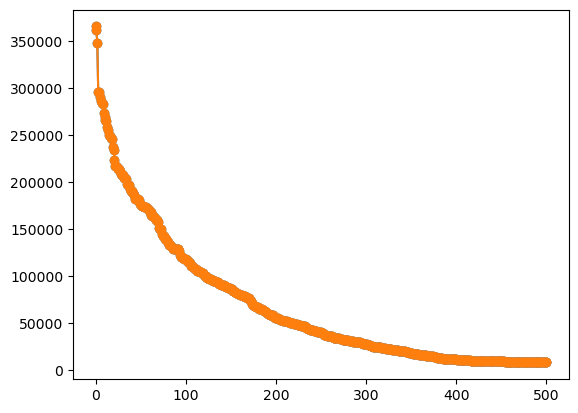

In [35]:
plt.plot(aic_criterion, color="tab:blue", marker="o", label="AIC criterion")
plt.plot(bic_criterion, color="tab:orange", marker="o", label="BIC criterion")

(2900000.0, 3100000.0)

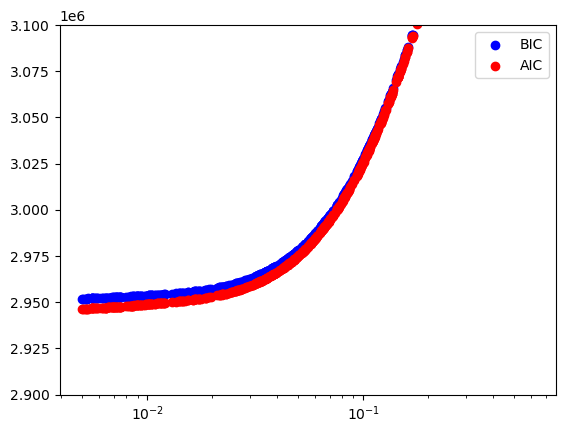

In [38]:
import matplotlib.pyplot as plt
plt.scatter(results.index, results["BIC criterion"].values, color="blue", label="BIC")
plt.scatter(results.index, results["AIC criterion"].values, color="red", label="AIC")
plt.xscale("log")
plt.legend()
plt.ylim(2.9e6, 3.1e6)

In [39]:
mod = Lasso(alpha=0.005).fit(trainx, trainy)

In [40]:
from scipy.stats import pearsonr
pearsonr(trainy, mod.predict(trainx))

PearsonRResult(statistic=0.5715374543913303, pvalue=0.0)

In [41]:
(np.abs(mod.coef_) > 1e-12).sum()

370

In [42]:
validpreds, validy = [], []
for idnum in tt_split["valid_ids"]:
    for f in tt_split["valid_ids"][idnum]["p"]:
        validpreds.append(mod.predict(np.load(f)))
    for f in tt_split["valid_ids"][idnum]["y"]:
        validy.append(np.load(f))

validpreds = np.concatenate(validpreds)
validy = np.concatenate(validy)

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/temp/BSS00483_0_promoters.npy'

In [43]:
#Don't forget to remove the temporary files created in scratch!!
shutil.rmtree("/scratch/temp")

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/temp'

In [53]:
(mod.coef_ < 1e-1).sum()

623

In [64]:
idx = np.where(np.abs(mod.coef_) > 1e-12)[0].tolist()

In [65]:
print(idx)

[1, 2, 4, 7, 9, 10, 11, 12, 13, 20, 21, 22, 23, 24, 26, 27, 29, 30, 31, 33, 36, 38, 39, 42, 45, 46, 48, 50, 51, 52, 53, 54, 57, 60, 61, 63, 64, 65, 66, 67, 68, 69, 71, 72, 73, 75, 81, 82, 83, 86, 87, 90, 93, 94, 95, 96, 99, 102, 106, 108, 109, 114, 116, 117, 118, 119, 123, 124, 125, 127, 128, 129, 130, 133, 134, 135, 136, 139, 140, 141, 142, 143, 145, 146, 147, 149, 150, 151, 153, 155, 156, 157, 159, 160, 162, 163, 164, 166, 168, 169, 171, 172, 173, 174, 175, 178, 179, 182, 183, 184, 185, 188, 192, 193, 196, 197, 198, 199, 200, 202, 203, 204, 206, 207, 209, 211, 212, 214, 215, 216, 219, 220, 225, 226, 229, 230, 231, 232, 234, 235, 236, 238, 241, 242, 243, 244, 249, 250, 251, 256, 258, 259, 260, 262, 264, 267, 269, 271, 273, 274, 276, 277, 279, 280, 281, 286, 290, 292, 293, 294, 295, 297, 299, 303, 304, 306, 307, 309, 310, 311, 314, 315, 316, 317, 318, 320, 321, 323, 324, 325, 328, 329, 331, 332, 333, 334, 335, 337, 338, 339, 340, 342, 343, 344, 345, 349, 350, 353, 355, 356, 357, 359, 3